Imports & Paths

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Base paths
BASE_DIR   = '/kaggle/input/zju-leaper/ZJU-Leaper/ZJU-Leaper/'
CSV_PATH   = os.path.join(BASE_DIR, 'statistic.csv')
JSON_PATH  = os.path.join(BASE_DIR, 'ImageSets/total.json')
IMAGES_DIR = os.path.join(BASE_DIR, 'Images')


Load & Visualize Statistics

Columns: ['p_name', 'p_id', 'normal', 'normal train', 'normal test', 'defective', 'defective train', 'defective test']


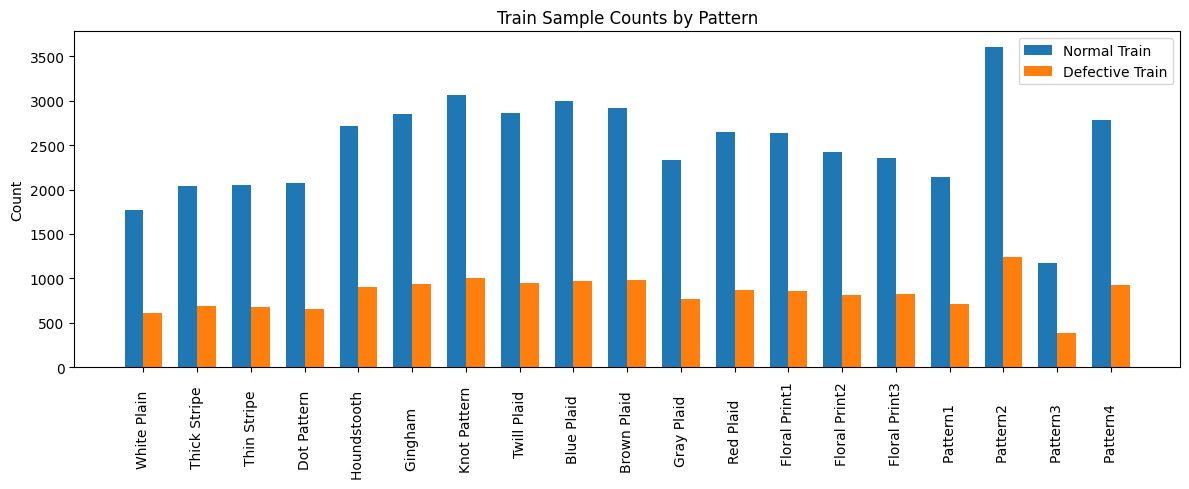

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
print("Columns:", df.columns.tolist())

plt.figure(figsize=(12,5))
x = np.arange(len(df))
w = 0.35

plt.bar(x - w/2, df['normal train'],   width=w, label='Normal Train')
plt.bar(x + w/2, df['defective train'], width=w, label='Defective Train')

plt.xticks(x, df['p_name'], rotation=90)
plt.ylabel('Count')
plt.title('Train Sample Counts by Pattern')
plt.legend()
plt.tight_layout()
plt.show()


Load Train/Test Splits

In [3]:
with open(JSON_PATH) as f:
    splits = json.load(f)

print("Normal — train:", len(splits['normal']['train']),
      " test:", len(splits['normal']['test']))
print("Defect — train:", len(splits['defect']['train']),
      " test:", len(splits['defect']['test']))


Normal — train: 47423  test: 23704
Defect — train: 15761  test: 7945


Dataset & DataLoader

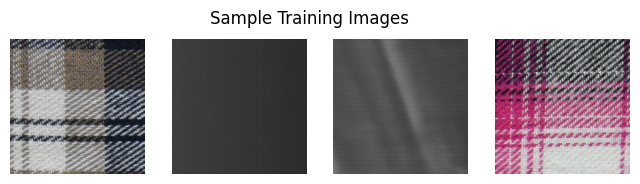

In [ ]:
class ZJULeaper(Dataset):
    def __init__(self, img_ids):
        self.ids = img_ids
        self.tf = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, i):
        img_id = self.ids[i]
        path = os.path.join(IMAGES_DIR, f"{img_id}.jpg")
        img = Image.open(path).convert('RGB')
        return self.tf(img)

# PyTorch datasets
train_ds = ZJULeaper(splits['normal']['train'])
val_ds   = ZJULeaper(splits['normal']['test'])
def_ds   = ZJULeaper(splits['defect']['test'])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)
def_loader   = DataLoader(def_ds,   batch_size=8, shuffle=False, num_workers=2)

batch = next(iter(train_loader))
plt.figure(figsize=(8,2))
for i in range(4):
    ax = plt.subplot(1,4,i+1)
    ax.imshow(batch[i].permute(1,2,0))
    ax.axis('off')
plt.suptitle("Sample Training Images")
plt.show()


Define the Convolutional Autoencoder

In [ ]:
import torch
import torch.nn as nn

class CAE(nn.Module):
    def __init__(self):
        super().__init__()
        # ---- Encoder ----
        self.enc = nn.Sequential(
            # Block 1: 512→256
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),

            # Block 2: 256→128
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),

            # Block 3: 128→64
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(128,128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
        )

        # ---- Decoder ----
        self.dec = nn.Sequential(
            # Block 1: 64→128
            nn.Conv2d(128,128,3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),

            # Block 2: 128→256
            nn.Conv2d(64,64,3,padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(64,32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),

            # Block 3: 256→512
            nn.Conv2d(32,32,3,padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.ConvTranspose2d(32,3,  kernel_size=4, stride=2, padding=1, bias=False),

            # final map
            nn.Sigmoid(),  # [0,1]
        )

    def forward(self, x):
        z = self.enc(x)
        return self.dec(z)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE().to(device)
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


CAE(
  (enc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

Train the CAE

In [7]:
 #pip install piqa

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from piqa import SSIM   

num_epochs = 30

mse_crit  = nn.MSELoss()
ssim_crit = SSIM(window_size=11).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scaler    = GradScaler()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

best_val = float('inf')
for epoch in range(1, num_epochs+1):
    # — train —
    model.train()
    running = 0.0
    for imgs in train_loader:
        imgs = imgs.to(device)

        # add noise:
        noisy = imgs + 0.05*torch.randn_like(imgs)
        noisy = noisy.clamp(0.0, 1.0)

        optimizer.zero_grad()
        with autocast():
            outputs   = model(noisy)
            loss_mse  = mse_crit(outputs, imgs)
            loss_ssim = 1.0 - ssim_crit(outputs, imgs).mean()
            loss      = loss_mse + 0.5 * loss_ssim

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)

    train_loss = running / len(train_loader.dataset)

    # — val —
    model.eval()
    running = 0.0
    with torch.no_grad():
        for imgs in val_loader:
            imgs = imgs.to(device)
            with autocast():
                outputs   = model(imgs)
                loss_mse  = mse_crit(outputs, imgs)
                loss_ssim = 1.0 - ssim_crit(outputs, imgs).mean()
                loss      = loss_mse + 0.5 * loss_ssim
            running += loss.item() * imgs.size(0)

    val_loss = running / len(val_loader.dataset)

    scheduler.step()
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), '/kaggle/working/cae_best.pth')

    print(f"Epoch {epoch:2d}/{num_epochs} — train: {train_loss:.6f}  val: {val_loss:.6f}")



/tmp/ipykernel_123/1677426326.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
/tmp/ipykernel_123/1677426326.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_123/1677426326.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch  1/30 — train: 0.256278  val: 0.159072
Epoch  2/30 — train: 0.184498  val: 0.134961
Epoch  3/30 — train: 0.168130  val: 0.118889
Epoch  4/30 — train: 0.152524  val: 0.107222
Epoch  5/30 — train: 0.148134  val: 0.099352
Epoch  6/30 — train: 0.147115  val: 0.129006
Epoch  7/30 — train: 0.143487  val: 0.101801
Epoch  8/30 — train: 0.138446  val: 0.101180
Epoch  9/30 — train: 0.137453  val: 0.097543
Epoch 10/30 — train: 0.132694  val: 0.096113
Epoch 11/30 — train: 0.133020  val: 0.100200
Epoch 12/30 — train: 0.129845  val: 0.095555
Epoch 13/30 — train: 0.129648  val: 0.120110
Epoch 14/30 — train: 0.137369  val: 0.110568
Epoch 15/30 — train: 0.136815  val: 0.106599
Epoch 16/30 — train: 0.132072  val: 0.094301
Epoch 17/30 — train: 0.132801  val: 0.099239
Epoch 18/30 — train: 0.127896  val: 0.088367
Epoch 19/30 — train: 0.126005  val: 0.087716
Epoch 20/30 — train: 0.124715  val: 0.088322
Epoch 21/30 — train: 0.125162  val: 0.088001
Epoch 22/30 — train: 0.124242  val: 0.091449
Epoch 23/3

Plot Training Curves

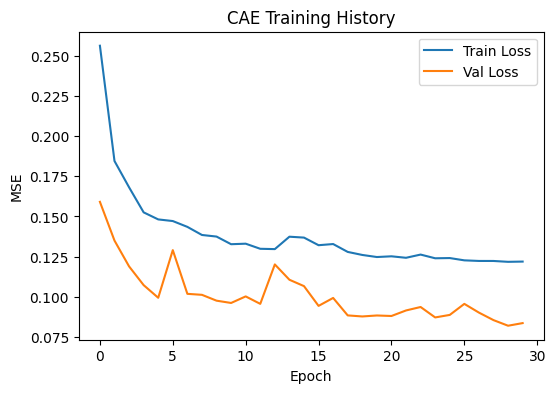

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()
plt.title('CAE Training History')
plt.show()


Reconstruction Error Distribution

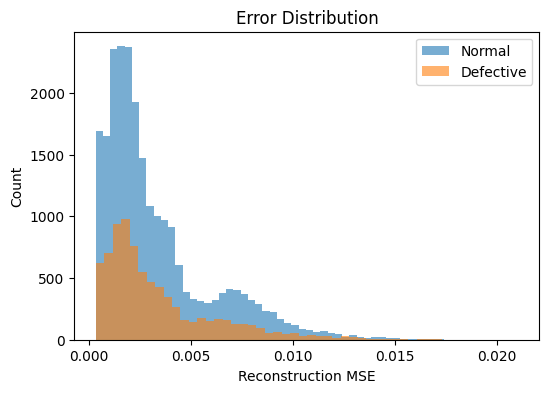

In [12]:
def get_errors(dl):
    errs = []
    model.eval()
    with torch.no_grad():
        for imgs in dl:
            imgs = imgs.to(device)
            outs = model(imgs)
            batch_err = ((outs - imgs)**2).mean(dim=(1,2,3)).cpu().numpy()
            errs.extend(batch_err)
    return np.array(errs)

err_norm   = get_errors(val_loader)
err_defect = get_errors(def_loader)

plt.figure(figsize=(6,4))
plt.hist(err_norm,   bins=50, alpha=0.6, label='Normal')
plt.hist(err_defect, bins=50, alpha=0.6, label='Defective')
plt.xlabel('Reconstruction MSE'); plt.ylabel('Count')
plt.title('Error Distribution'); plt.legend()
plt.show()


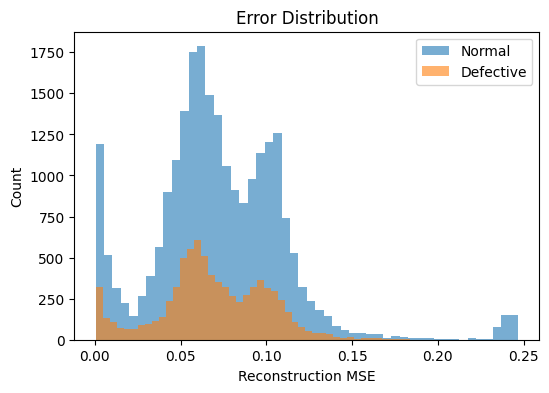

In [46]:
def get_errors(dl):
    errs = []
    model.eval()
    with torch.no_grad():
        for imgs in dl:
            imgs = imgs.to(device)
            outs = model(imgs)
            batch_err = ((outs - imgs)**2).mean(dim=(1,2,3)).cpu().numpy()
            errs.extend(batch_err)
    return np.array(errs)

err_norm   = get_errors(val_loader)
err_defect = get_errors(def_loader)

plt.figure(figsize=(6,4))
plt.hist(err_norm,   bins=50, alpha=0.6, label='Normal')
plt.hist(err_defect, bins=50, alpha=0.6, label='Defective')
plt.xlabel('Reconstruction MSE'); plt.ylabel('Count')
plt.title('Error Distribution'); plt.legend()
plt.show()


Visualize Reconstructions

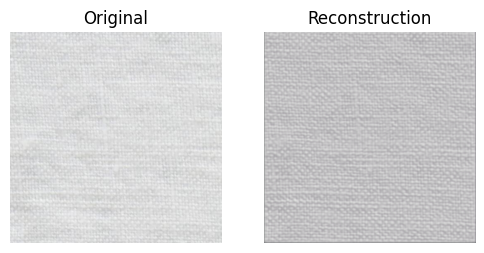

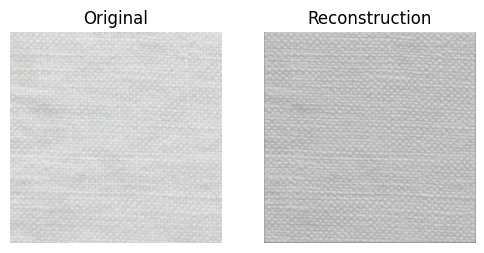

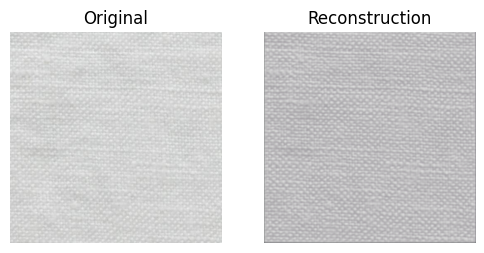

In [13]:
sample_imgs = next(iter(val_loader)).to(device)
recons     = model(sample_imgs)

for i in range(3):
    orig = sample_imgs[i].permute(1,2,0).detach().cpu().numpy()
    rec  = recons[i].permute(1,2,0).detach().cpu().numpy()

    fig, axes = plt.subplots(1,2,figsize=(6,3))
    axes[0].imshow(orig)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(rec)
    axes[1].set_title('Reconstruction')
    axes[1].axis('off')

    plt.show()


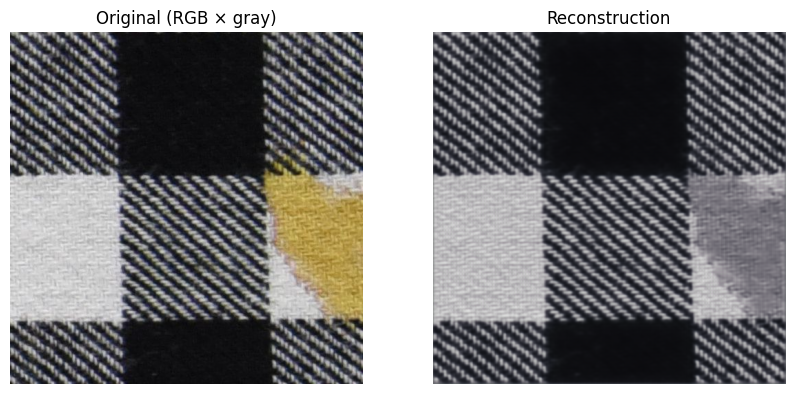

In [ ]:
model.eval()
model.to(device)


img_path = "/kaggle/input/zju-leaper/ZJU-Leaper/Images/025756.jpg"


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),               
])


img_pil = Image.open(img_path).convert("RGB")
inp = transform(img_pil).unsqueeze(0).to(device)  


with torch.no_grad():
    recon = model(inp)


orig_np  = inp .squeeze(0).permute(1,2,0).cpu().numpy()  
recon_np = recon.squeeze(0).permute(1,2,0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(orig_np)
axes[0].set_title("Original (RGB × gray)")
axes[0].axis('off')

axes[1].imshow(recon_np)
axes[1].set_title("Reconstruction")
axes[1].axis('off')

plt.show()


In [17]:
import torch

# Save the trained model’s state_dict
torch.save(model.state_dict(), '/kaggle/working/cae_model.pth')
print("Saved to /kaggle/working/cae_model.pth")


Saved to /kaggle/working/cae_model.pth


In [30]:
ckpt = torch.load("/kaggle/working/cae_best.pth", map_location="cpu")
for k, v in ckpt.items():
    print(f"{k:<35} {tuple(v.shape)}")


enc.0.weight                        (32, 3, 3, 3)
enc.1.weight                        (32,)
enc.1.bias                          (32,)
enc.1.running_mean                  (32,)
enc.1.running_var                   (32,)
enc.1.num_batches_tracked           ()
enc.4.weight                        (32, 32, 3, 3)
enc.5.weight                        (32,)
enc.5.bias                          (32,)
enc.5.running_mean                  (32,)
enc.5.running_var                   (32,)
enc.5.num_batches_tracked           ()
enc.8.weight                        (64, 32, 3, 3)
enc.9.weight                        (64,)
enc.9.bias                          (64,)
enc.9.running_mean                  (64,)
enc.9.running_var                   (64,)
enc.9.num_batches_tracked           ()
enc.12.weight                       (64, 64, 3, 3)
enc.13.weight                       (64,)
enc.13.bias                         (64,)
enc.13.running_mean                 (64,)
enc.13.running_var                  (64,)
enc.13.n

/tmp/ipykernel_123/4129207434.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/kaggle/working/cae_best.pth", map_location="cpu")


/tmp/ipykernel_31/543809628.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT, map_location=device))


Threshold (95th percentile of train): 0.007913
✅ Accuracy : 0.7238
✅ Precision: 0.2632
✅ Recall   : 0.0558
✅ F1‑Score : 0.0920
✅ ROC AUC  : 0.5097


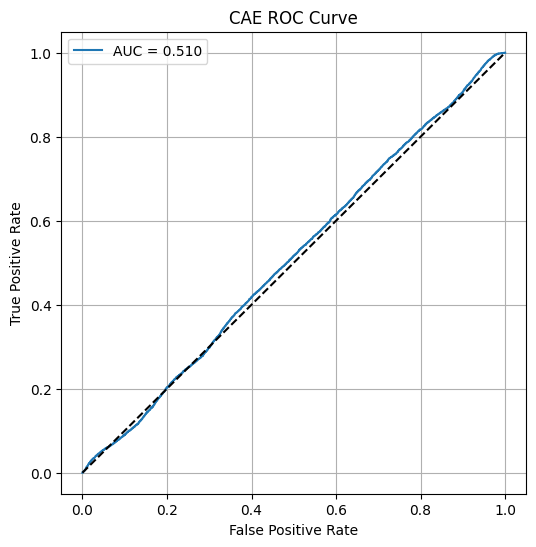

In [ ]:
with open(JSON_PATH, "r") as f:
    splits = json.load(f)
normal_train_ids = splits["normal"]["train"]
normal_test_ids  = splits["normal"]["test"]
defect_test_ids  = splits["defect"]["test"]

class ZJULeaper(Dataset):
    def __init__(self, img_ids, transform):
        self.ids = img_ids
        self.transform = transform
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        path = os.path.join(IMAGES_DIR, f"{img_id}.jpg")
        img = Image.open(path).convert("RGB")
        return self.transform(img)

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

bs = 16
train_loader = DataLoader(ZJULeaper(normal_train_ids, transform), batch_size=bs, shuffle=False)
norm_loader  = DataLoader(ZJULeaper(normal_test_ids,  transform), batch_size=bs, shuffle=False)
def_loader   = DataLoader(ZJULeaper(defect_test_ids,  transform), batch_size=bs, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAE().to(device)
model.load_state_dict(torch.load(CHECKPOINT, map_location=device))
model.eval()

def get_reconstruction_errors(model, loader):
    errors = []
    with torch.no_grad():
        for imgs in loader:
            imgs = imgs.to(device)
            recons = model(imgs)
            mse = ((imgs - recons) ** 2).mean(dim=[1,2,3]).cpu().numpy()
            errors.extend(mse)
    return np.array(errors)

train_err = get_reconstruction_errors(model, train_loader)
threshold = np.percentile(train_err, 95)
print(f"Threshold (95th percentile of train): {threshold:.6f}")

norm_err   = get_reconstruction_errors(model, norm_loader)
defect_err = get_reconstruction_errors(model, def_loader)

y_true   = np.concatenate([np.zeros_like(norm_err), np.ones_like(defect_err)])
y_scores = np.concatenate([norm_err, defect_err])
y_pred   = (y_scores > threshold).astype(int)

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)
auc  = roc_auc_score(y_true, y_scores)

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall   : {rec:.4f}")
print(f"✅ F1‑Score : {f1:.4f}")
print(f"✅ ROC AUC  : {auc:.4f}")

# 12. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CAE ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Threshold (70th percentile of train): 0.003481
✅ Accuracy : 0.5985
✅ Precision: 0.2494
✅ Recall   : 0.2983
✅ F1‑Score : 0.2717
✅ ROC AUC  : 0.5097


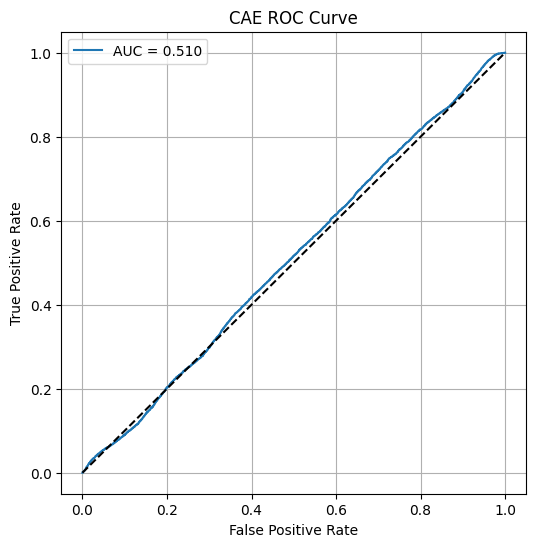

In [ ]:

train_err = get_reconstruction_errors(model, train_loader)
threshold = np.percentile(train_err, 70)
print(f"Threshold (70th percentile of train): {threshold:.6f}")


norm_err   = get_reconstruction_errors(model, norm_loader)
defect_err = get_reconstruction_errors(model, def_loader)

y_true   = np.concatenate([np.zeros_like(norm_err), np.ones_like(defect_err)])
y_scores = np.concatenate([norm_err, defect_err])
y_pred   = (y_scores > threshold).astype(int)

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)
auc  = roc_auc_score(y_true, y_scores)

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall   : {rec:.4f}")
print(f"✅ F1‑Score : {f1:.4f}")
print(f"✅ ROC AUC  : {auc:.4f}")

# 12. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CAE ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

Reconstruction MSE: 0.004261
❌ Classified as DEFECTIVE


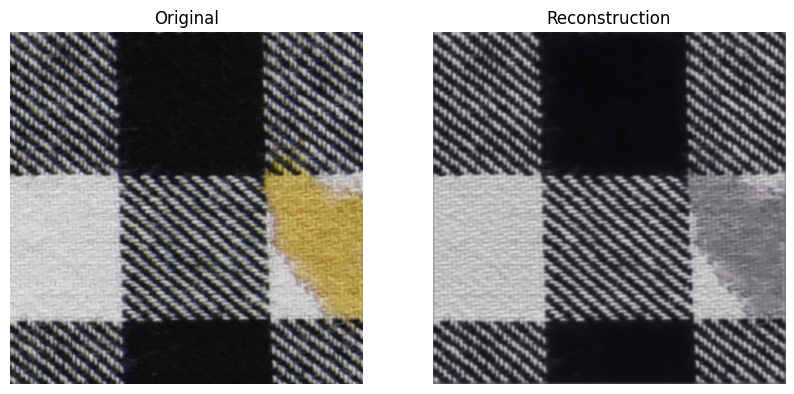

In [ ]:

img_path = "/kaggle/input/zju-leaper/ZJU-Leaper/Images/025756.jpg"

img_pil = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
img_tensor = transform(img_pil).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    recon = model(img_tensor)


mse_error = ((img_tensor - recon) ** 2).mean().item()
print(f"Reconstruction MSE: {mse_error:.6f}")


if mse_error > threshold:
    print("❌ Classified as DEFECTIVE")
else:
    print("✅ Classified as NORMAL")

orig_np  = img_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
recon_np = recon.squeeze(0).permute(1,2,0).cpu().numpy()
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(orig_np)
axes[0].set_title("Original")
axes[0].axis('off')
axes[1].imshow(recon_np)
axes[1].set_title("Reconstruction")
axes[1].axis('off')
plt.show()


Image: 002680.jpg, Reconstruction MSE: 0.004316
❌ Classified as DEFECTIVE


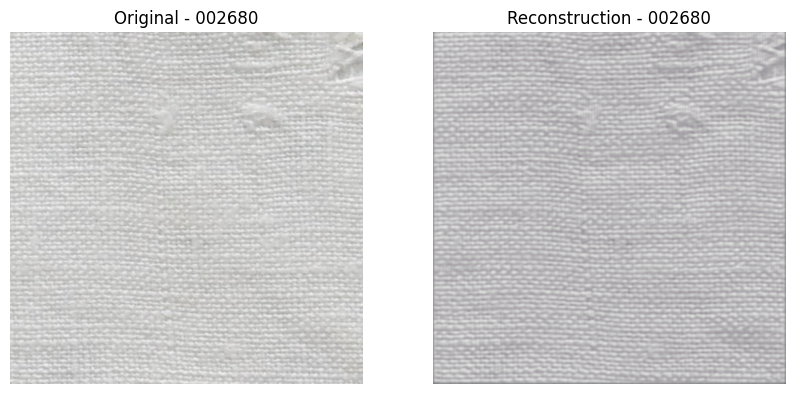

Error: Image not found at /kaggle/input/zju-leaper/ZJU-Leaper/Images/094833078785.jpg
Image: 060445.jpg, Reconstruction MSE: 0.000993
✅ Classified as NORMAL


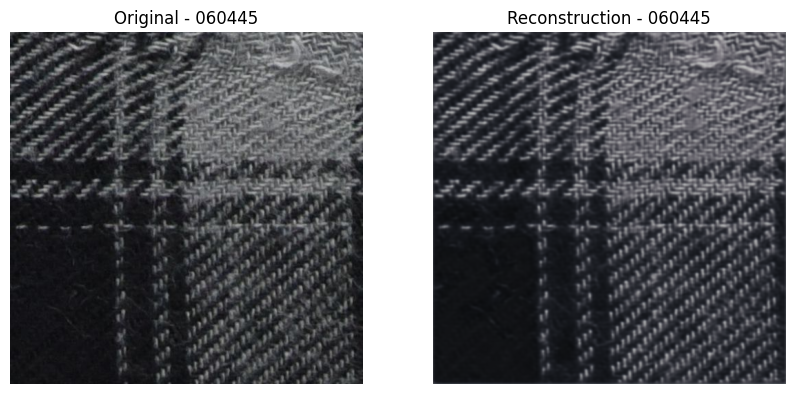

Image: 054492.jpg, Reconstruction MSE: 0.001280
✅ Classified as NORMAL


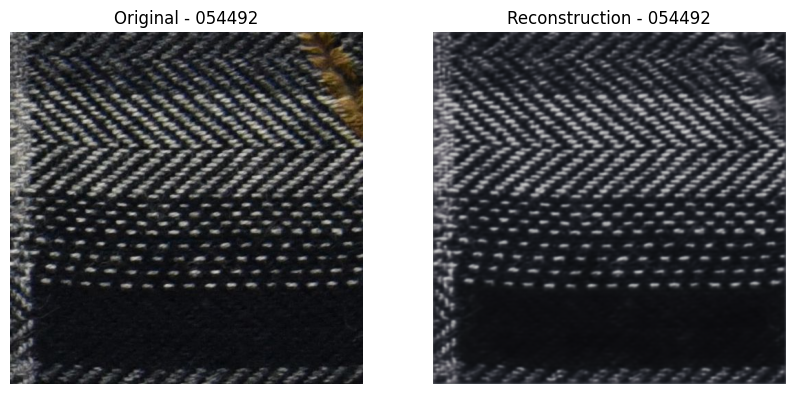

Image: 002712.jpg, Reconstruction MSE: 0.004033
❌ Classified as DEFECTIVE


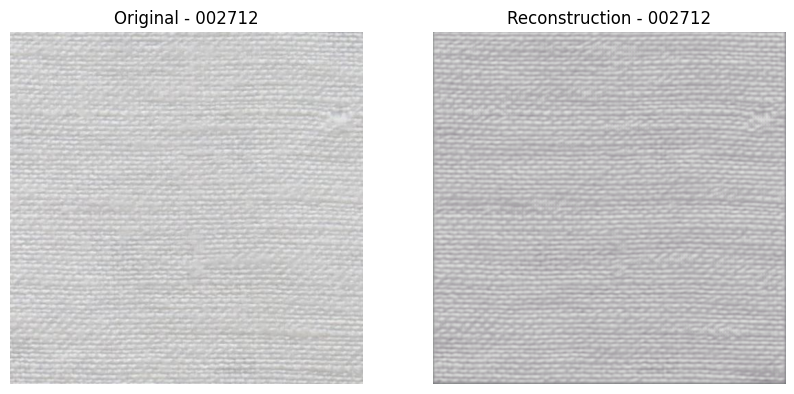

Image: 006645.jpg, Reconstruction MSE: 0.002449
✅ Classified as NORMAL


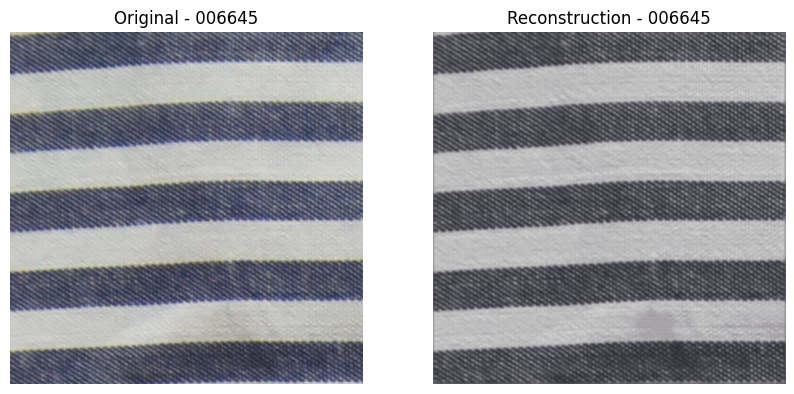

Image: 094461.jpg, Reconstruction MSE: 0.000491
✅ Classified as NORMAL


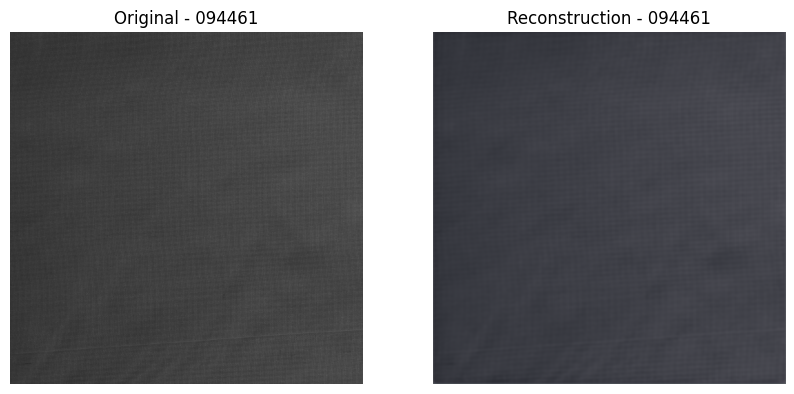

Image: 086781.jpg, Reconstruction MSE: 0.001015
✅ Classified as NORMAL


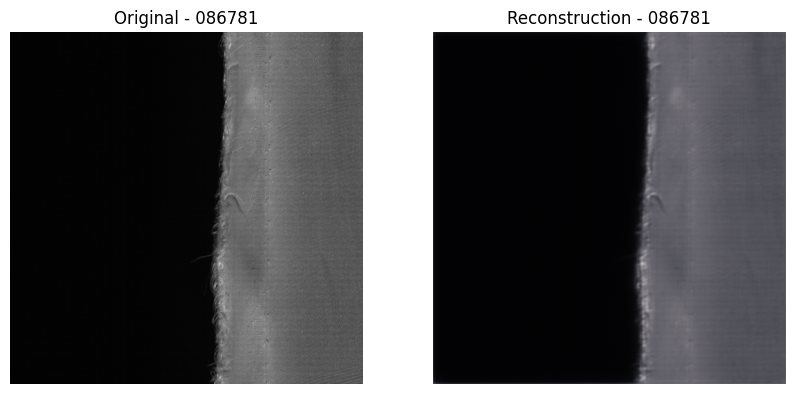

Image: 075171.jpg, Reconstruction MSE: 0.003876
❌ Classified as DEFECTIVE


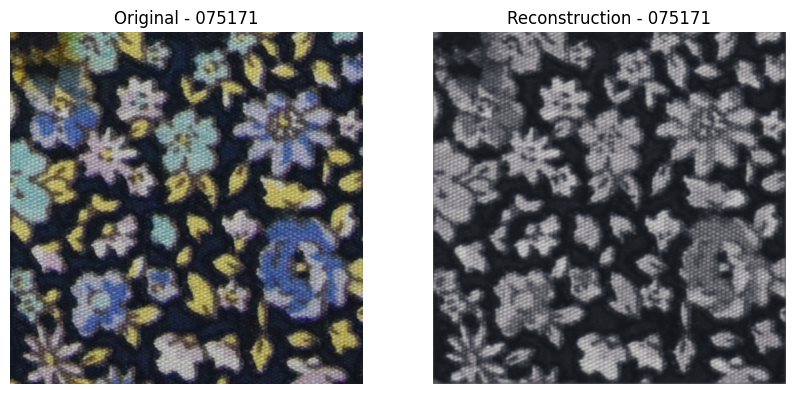

Image: 060048.jpg, Reconstruction MSE: 0.001002
✅ Classified as NORMAL


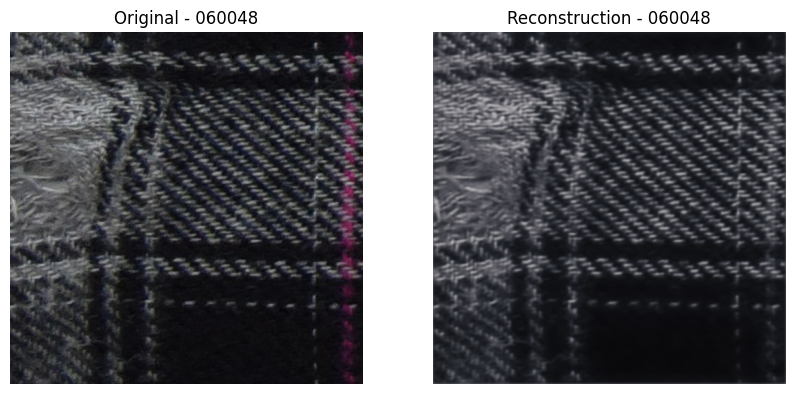

Image: 059957.jpg, Reconstruction MSE: 0.010942
❌ Classified as DEFECTIVE


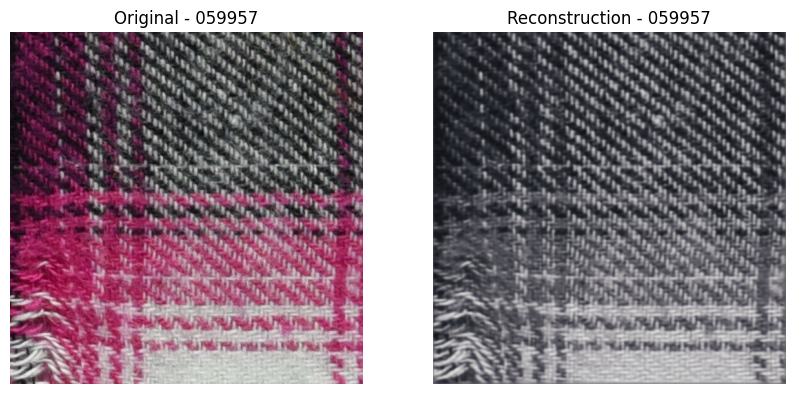

Image: 049912.jpg, Reconstruction MSE: 0.002051
✅ Classified as NORMAL


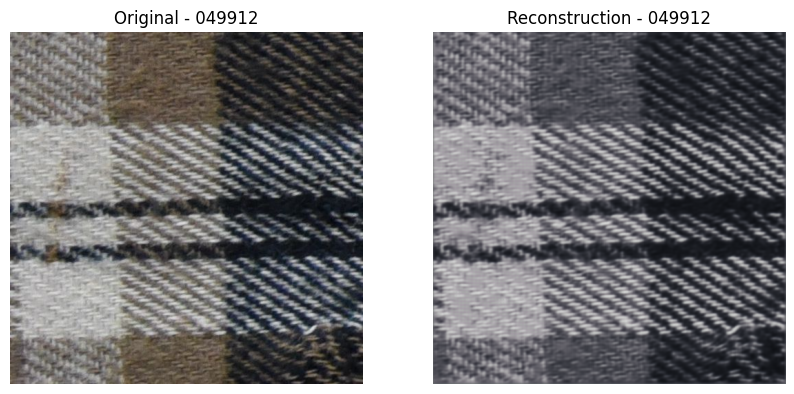

Image: 038188.jpg, Reconstruction MSE: 0.001994
✅ Classified as NORMAL


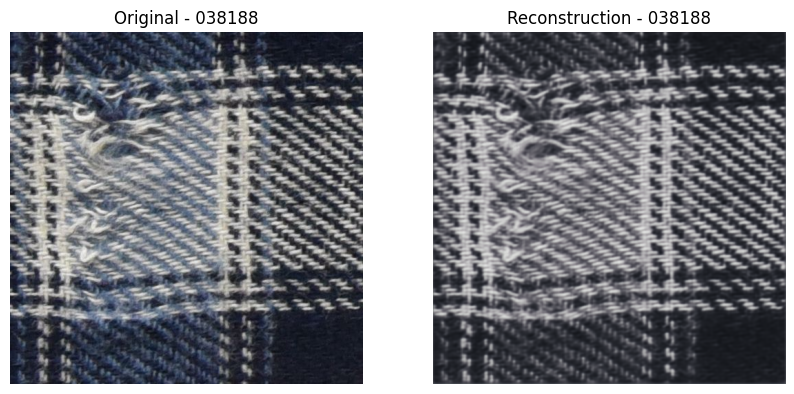

In [ ]:
# note: the code is ai generated
image_filenames = [
    "002680",
    "094833"
    "078785",
    "060445",
    "054492",
    "002712",
    "006645",
    "094461",
    "086781",
    "075171",
    "060048",
     "059957",
    "049912",
    "038188",
]
base_image_dir = "/kaggle/input/zju-leaper/ZJU-Leaper/Images/"
for img_filename in image_filenames:
    # Construct the full image path
    img_path = os.path.join(base_image_dir, f"{img_filename}.jpg")

    try:
        # Load and preprocess the image
        img_pil = Image.open(img_path).convert("RGB")
        transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
        ])
        img_tensor = transform(img_pil).unsqueeze(0).to(device)

        # Forward pass through the model
        model.eval()
        with torch.no_grad():
            recon = model(img_tensor)

        # Compute reconstruction error (MSE)
        mse_error = ((img_tensor - recon) ** 2).mean().item()
        print(f"Image: {img_filename}.jpg, Reconstruction MSE: {mse_error:.6f}")

        # Compare with threshold
        if mse_error > threshold:
            print("❌ Classified as DEFECTIVE")
        else:
            print("✅ Classified as NORMAL")

        # Visualize (optional)
        orig_np  = img_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
        recon_np = recon.squeeze(0).permute(1,2,0).cpu().numpy()
        fig, axes = plt.subplots(1, 2, figsize=(10,5))
        axes[0].imshow(orig_np)
        axes[0].set_title(f"Original - {img_filename}")
        axes[0].axis('off')
        axes[1].imshow(recon_np)
        axes[1].set_title(f"Reconstruction - {img_filename}")
        axes[1].axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"Error: Image not found at {img_path}")
    except Exception as e:
        print(f"An error occurred while processing {img_filename}.jpg: {e}")

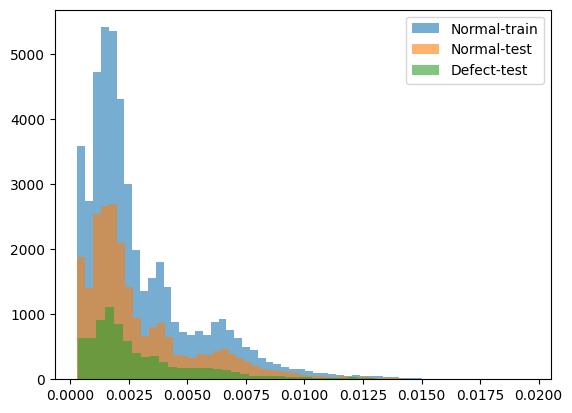

In [27]:
plt.hist(train_err,   bins=50, alpha=0.6, label="Normal‑train")
plt.hist(norm_err,    bins=50, alpha=0.6, label="Normal‑test")
plt.hist(defect_err,  bins=50, alpha=0.6, label="Defect‑test")
plt.legend(); plt.show()
